<a href="https://colab.research.google.com/github/RachelRamirez/FashionMNIST_DataAugmentation/blob/main/Fashion_mnist_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Simple (Fashion) MNIST convnet" Architecture with Extremely Limited Data used to Train CNN

**Original Author with MNIST:** [fchollet](https://twitter.com/fchollet)<br>
Date created: 2015/06/19<br>

**Modified to Fashion MNIST** [rachelramirez](https://github.com/RachelRamirez/FashionMNIST_DataAugmentation) 2021/08/25

**Description:** A simple convnet architecture for training on Fashion MNIST, is frozen and then data augmentation techniques are attempted as a Design of Experiment (DOE).

Then data is limited to varying levels of sample sizes  [500, 1000]  to view the effect of data augmentation on increasing model accuracy.

More features are added to original notebook for residual/error analysis such as confusion matrix and data augmentation.

In [10]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files

print(tf. __version__) 


2.6.0


# Experiment

The first part of this experiment is looking at the space for *TrainingSize*, *ValidationSize*, *BatchSize*, and *EpochSize*.  These all likely effect one another (4-way interactions) so a DOE design is used to look at Response Surface Methods.

A: BatchSize (10, 100)

B: Epochs  (15, 50)

C: Training Size (Count)  (100, 1000)

D: Validation (as percentage of Training Size)  (20%, 50%) 

Replicates: 2
Center Points: 1

## Prepare the data

In [22]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Until the end of all analysis I don't really want to look at the real test set results
# I'm overwriting them to make sure I don't accidentally use them

x_test = []
y_test = []




# I decide to take a small dataset - 2000 samples of the 60000, and use that to 
# create a TRAIN Set of up to 1000 samples, a VALIDATION Set of up to 1000 samples, and a FAKE-TEST set of the remaining 58000
# After Analyzing the best "Augmentation Effect" I wil apply it to the "REAL" Test DataSet to see if it improved.


# Validation Set is 1000 
x_val = x_train[1000:2000]
y_val = y_train[1000:2000]

#My FAKE Test Set is 58000
x_test = x_train[2000:60000]
y_test = y_train[2000:60000]


# Finally I change train dataset to first 1000
x_train = x_train[0:1000]
y_train = y_train[0:1000]

#My holdout Test Set after all the DOE is the original TEST set from dataset


print("Fashion MNIST has training size up to: ", y_train.shape, ", val set of , ", y_val.shape, " and test set of ", y_test.shape)


# Scale images to the [0, 1] range
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255    # put into preprocessing model step
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "fake test samples saved from test-set")
print(x_val.shape[0], "validation samples")



# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Try to put in tensor flow shape
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)


# Define Manual Validation Set
valid_set = (x_val, y_val)


Fashion MNIST has training size up to:  (1000,) , val set of ,  (1000,)  and test set of  (58000,)
x_train shape: (1000, 28, 28, 1)
1000 train samples
58000 fake test samples
1000 validation samples


## Build the model

In [43]:
dataAugmentation = False
randseed = 42 

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", seed = randseed),  # I assume vertical would be very bad
  layers.experimental.preprocessing.RandomRotation(0.02, seed = randseed),  # I visualized what 5 degrees looked like and it was rough
  layers.experimental.preprocessing.RandomContrast(factor=0.5, seed = randseed) # I don't really understand this yet
])


if dataAugmentation == False:
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(num_classes, activation="softmax"),
      ]
  )
else:
    model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
          data_augmentation,  ## <---
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(num_classes, activation="softmax"),
      ]
  )
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1600)            

# Insert DOE Variables -> Train Model

In [32]:
experiment = False

## Experiment 1 'Global' Variables
if experiment == True: 
  var_BatchSize =  10, 25, 50, 100
  var_Epochs =     50, 70
  var_TrainSize = 100, 505, 1000
  #var_ValPercent = 0.2, 0.3
else:
  var_BatchSize =  10, 10
  var_Epochs =     50, 50
  var_TrainSize = 100, 100
  #var_ValPercent = 0.2, 0.2

 

## Train the model

In [33]:
counter = 1
scorelist = []


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
## Save Weight is to help Reset the model before Training, very important, otherwise you get better results every run!
model.save_weights('model.h5') 



for t in var_TrainSize:
  new_x_train = x_train[0:t]  
  new_y_train = y_train[0:t]


  for b in var_BatchSize:
    for e in var_Epochs:
      # for v in var_ValPercent:
      # batch_size = b
      epochs = e


      model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
      model.load_weights('model.h5')

      # Verbose  = 0 after I verified everything was working to improve overall speed
      %%timeit
      model.fit(new_x_train, new_y_train, batch_size=b, epochs=e,  validation_data=valid_set, verbose=0)

      score = model.evaluate(x_test, y_test, verbose=0)
      # print("Test loss:", score[0])
      # print("Test accuracy:", score[1])
      scorelist += [ [counter, b,  e,    t,    score[0], score[1]] ]
      print("This is run", counter, ": ", b, e, t,  "had accuracy: ", score[1], " test loss: ", score[0])
      counter=counter+1

#save scorelist as a csv file
if dataAugmentation:
  filename = 'data_augmented.csv'
else:
    filename = "data.csv"

np.savetxt(filename, scorelist, delimiter=',')


This is run 1 :  10 50 100 had accuracy:  0.7203620672225952  test loss:  1.0421149730682373
This is run 2 :  10 50 100 had accuracy:  0.7128620743751526  test loss:  1.0782170295715332
This is run 3 :  10 50 100 had accuracy:  0.7055344581604004  test loss:  1.0875916481018066
This is run 4 :  10 50 100 had accuracy:  0.7008965611457825  test loss:  1.0927430391311646
This is run 5 :  10 50 100 had accuracy:  0.7153103351593018  test loss:  1.0869548320770264
This is run 6 :  10 50 100 had accuracy:  0.7120344638824463  test loss:  1.0689553022384644
This is run 7 :  10 50 100 had accuracy:  0.6985344886779785  test loss:  1.1049394607543945
This is run 8 :  10 50 100 had accuracy:  0.7136896848678589  test loss:  1.066351294517517


In [34]:
#save file to my personal computer so I don't lose it to google colab timeout

#why isn't this working?! :-( 
#files.download('data.csv') 

In [35]:
# batch_size = 50
# epochs = 30

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.5)

## Evaluate the trained model

In [36]:
          # score = model.evaluate(x_test, y_test, verbose=1)
          # print("Test loss:", score[0])
          # print("Test accuracy:", score[1])

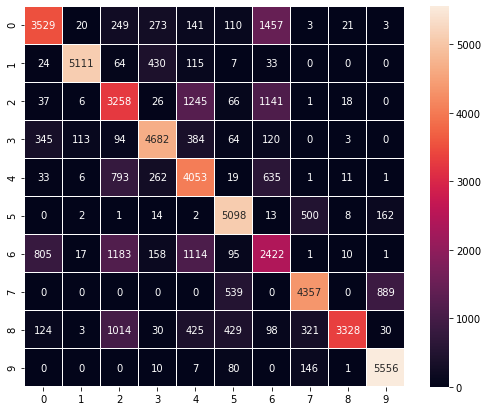

In [37]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
 
y_test = np.argmax(y_test, axis=1) 

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
#confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


In my first run, no data augmentation, 100 random samples of the Training Set, using 50% of that as the Validation Set, using a Batch Size of 50 and Epochs = 30, the resulting accuracy of the test-set is Test loss: 0.912209689617157
Test accuracy: 0.6866999864578247

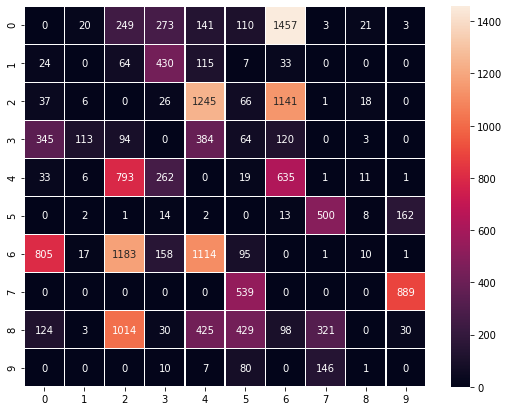

array([6, 3, 6, 1, 2, 7, 0, 5, 0, 7])

array([6, 3, 4, 4, 2, 7, 2, 9, 2, 7])

<tf.Tensor: shape=(), dtype=float64, numpy=16606.0>

In [38]:
## I want to pick the largest value on the confusion matrix not on the diagonal
confusing_part_matrix= np.array(confusion_matrix)-np.identity(confusion_matrix.shape[0])*np.diag(confusion_matrix)

confusing_part_matrix = tf.convert_to_tensor(confusing_part_matrix)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusing_part_matrix,
    annot=True,
    linewidths=.5
    ,fmt='.0f'
    #,fmt="d"
    #,square=True
    #,ax=ax
)
plt.show()


## find the max value of those remaining numbers
thisnumber=np.max(confusing_part_matrix)

x_thisnumber=np.argmax(confusing_part_matrix,axis=0)
y_thisnumber=np.argmax(confusing_part_matrix,axis=1)
z_thisnumber=np.argmax(confusing_part_matrix)
display(x_thisnumber,y_thisnumber)
#print("The worst the algorithm did is between " confus)

display(sum(sum(confusing_part_matrix)))
 

In [39]:
delta = predictions - y_test

wrong = tf.boolean_mask(x_test, delta)

#  if i != 0
#    display("Prediction ", i, " is " + LABEL_NAMES[predictions[i]], "but it is ",  LABEL_NAMES[y_test[i] )


In [40]:
confusing_part_matrix[0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([   0.,   20.,  249.,  273.,  141.,  110., 1457.,    3.,   21.,
          3.])>

In [41]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
z_thisnumber=np.argmax(confusing_part_matrix)
z_thisnumber
print("The algorithm misrecognizes a lot of class " ,  LABEL_NAMES[np.math.floor(z_thisnumber/10)] , " as class ",  LABEL_NAMES[z_thisnumber%10])



The algorithm misrecognizes a lot of class  t_shirt  as class  shirt


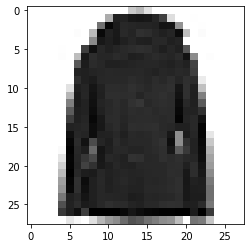

In [42]:
plt.imshow(x_test[0].reshape((28,28)), cmap=plt.cm.binary)
plt.show()